<a href="https://colab.research.google.com/github/abdyraman/images_class/blob/main/photo_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from random import randint
import tensorflow_hub as hub

import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

In [18]:
import tensorflow as tf
import tensorflow_hub as hub

# Specify the model name you want to use
model_name = "mobilenetv2-035-128"

# Define the model URL using TensorFlow Hub
model_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"  # You can change the version as needed

model_handle_map = {
  "mobilenetv2-035-128": model_url,
}

# Define the image size for the model
model_image_size_map = {
  "mobilenetv2-035-128": (224, 224)
}

# Get the model handle from the map
model_handle = model_handle_map[model_name]

print(f"Selected model: {model_name} : {model_handle}")

# Load the MobileNetV2 model from TensorFlow Hub
model = tf.keras.Sequential([
    hub.KerasLayer(model_handle, input_shape=(model_image_size_map[model_name][0], model_image_size_map[model_name][1], 3))
])

# Now you can use the model for image classification

# Before using the model for classification, make sure to resize your input images to (224, 224).
# For example, if you have an image img, you can resize it as follows:
# img = tf.image.resize(img, (224, 224))


Selected model: mobilenetv2-035-128 : https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4


# Import Images and Labels

In [19]:
images_path = '/content/Images'

labels_df = pd.read_csv('/content/metadata.csv')
print('\n\nlabels dataframe: \n', labels_df.head(), '\n\n')

class_names = ('clean', 'dirty')
num_classes = len(class_names)

img_size = (224, 224, 3)

print(f'{num_classes} classes: {class_names}\nimage size: {img_size}')


labels = []
images = []

for index, row in labels_df.iterrows():
    file_path = images_path + '/' + row['filename']  # Construct the full file path
    image = cv2.imread(file_path, cv2.IMREAD_COLOR)

    if image is not None:
        image = cv2.resize(image, (img_size[1], img_size[0]))  # Resize
        image = image[:, :, ::-1]  # BGR to RGB
        images.append(image)

        # Labels will be in the form of a vector: [0, 1] or [1, 0]
        label = np.zeros(num_classes)
        label[row['label']] = 1
        labels.append(label)

labels = np.asarray(labels)
images = np.asarray(images)

print(f'labels shape: {labels.shape}')
print(f'images shape: {images.shape}')



labels dataframe: 
         filename  label
0    dirty_2.jpg      1
1   clean_36.jpg      0
2   clean_31.jpg      0
3   dirty_69.jpg      1
4  clean_113.jpg      0 


2 classes: ('clean', 'dirty')
image size: (224, 224, 3)
labels shape: (237, 2)
images shape: (237, 224, 224, 3)


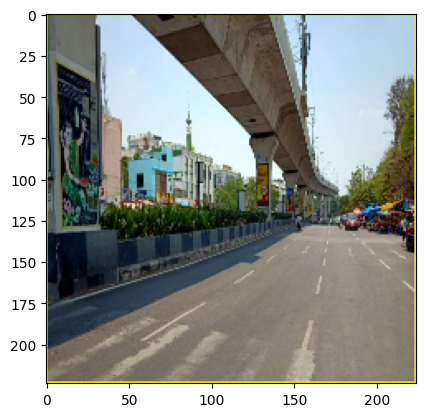

In [20]:
plt.imshow(images[1])

The first example image is this clean street above. We will plug this into the classifier to see what objects it detects.

In [21]:
#PROCESS IMAGE UTILITY
def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)
  return image

In [22]:
#SHOW IMAGE UTILITY
def show_image(image, title=''):
  image_size = image.shape[1]
  w = (image_size * 6) // 320
  plt.figure(figsize=(w, w))
  plt.imshow(image[0], aspect='equal')
  plt.axis('off')
  plt.title(title)
  plt.show()

# Warmup

> It is a good idea to warm up the classifier to see if the data is flowing properly

In [23]:
demoImage = preprocess_image(images[1])
classifier = hub.load(model_handle)

input_shape = demoImage.shape
warmup_input = tf.random.uniform(input_shape, 0, 1.0)
%time warmup_logits = classifier(warmup_input).numpy()

CPU times: user 471 ms, sys: 20.8 ms, total: 491 ms
Wall time: 566 ms


# Retrieve Pre-Defined Labels from Google

> This model was already set up with specific classes. Lets retrieve those so we can understand the context of the softmax scoring.



In [24]:
max_dynamic_size = 512
if model_name in model_image_size_map:
  image_size = model_image_size_map[model_name]
  dynamic_size = False
  print(f"Images will be converted to {image_size}x{image_size}")
else:
  dynamic_size = True
  print(f"Images will be capped to a max size of {max_dynamic_size}x{max_dynamic_size}")

labels_file = "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"

#download labels and creates a maps
downloaded_file = tf.keras.utils.get_file("labels.txt", origin=labels_file)

classes = []

with open(downloaded_file) as f:
  labels = f.readlines()
  classes = [l.strip() for l in labels]

Images will be converted to (224, 224)x(224, 224)
10484/10484 [==============================] - 0s 0us/step


CPU times: user 45.7 ms, sys: 3.07 ms, total: 48.8 ms
Wall time: 38.3 ms
(1)  719 - pier: 0.06854645907878876
(2)  868 - trailer truck: 0.042042624205350876
(3)  822 - steel arch bridge: 0.032504092901945114
(4)  583 - grocery store: 0.03131440654397011
(5)  874 - triumphal arch: 0.023163791745901108


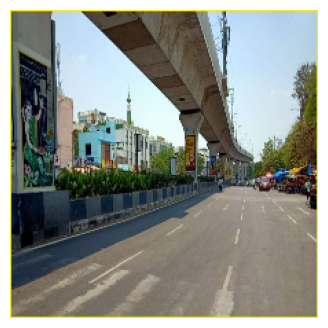

In [25]:
# Run model on image
%time probabilities = tf.nn.softmax(classifier(demoImage)).numpy()

top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()
np_classes = np.array(classes)

# Some models include an additional 'background' class in the predictions, so
# we must account for this when reading the class labels.
includes_background_class = probabilities.shape[1] == 1001

for i, item in enumerate(top_5):
  class_index = item if includes_background_class else item + 1
  line = f'({i+1}) {class_index:4} - {classes[class_index]}: {probabilities[0][top_5][i]}'
  print(line)

show_image(demoImage, '')

Now lets see what happens when we feed it a more chaotic image, like one of the 'dirty' images that we have from our data.

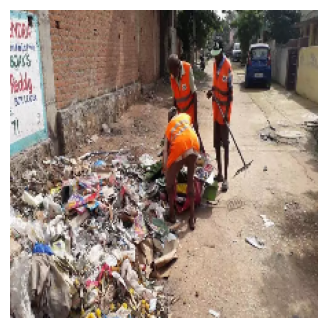

In [26]:
demoImage = preprocess_image(images[120])
show_image(demoImage, '')

CPU times: user 49.4 ms, sys: 4.84 ms, total: 54.2 ms
Wall time: 35 ms
(1)  492 - chain saw: 0.22036726772785187
(2)  671 - motor scooter: 0.21492543816566467
(3)  429 - barrow: 0.1748601645231247
(4)  666 - moped: 0.0593167282640934
(5)  831 - stretcher: 0.02478432096540928


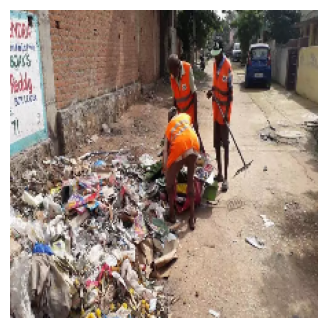

In [27]:
# Run model on image
%time probabilities = tf.nn.softmax(classifier(demoImage)).numpy()

top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()
np_classes = np.array(classes)

includes_background_class = probabilities.shape[1] == 1001

for i, item in enumerate(top_5):
  class_index = item if includes_background_class else item + 1
  line = f'({i+1}) {class_index:4} - {classes[class_index]}: {probabilities[0][top_5][i]}'
  print(line)

show_image(demoImage, '')

# Scenario 2: Transfer

> This scenario is very similar in set up to the previous one, but now we have more control over how our problem is defined and what labels we can use. In the following example, I am going to take the feature vector for ImageNet and train it on a subset of the clean/dirty images. Then I will see how well it does adapting to the binary classification problem that is more relevant to this dataset.

In [28]:
# Specify the model name you want to use
model_name = "mobilenetv2-035-128"

# Define the model URL using TensorFlow Hub
model_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"  # You can change the version as needed

model_handle_map = {
  "mobilenetv2-035-128": model_url,
}

# Define the image size for the model
model_image_size_map = {
  "mobilenetv2-035-128": (224, 224)
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 4

Selected model: mobilenetv2-035-128 : https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4
Input size ((224, 224), (224, 224))


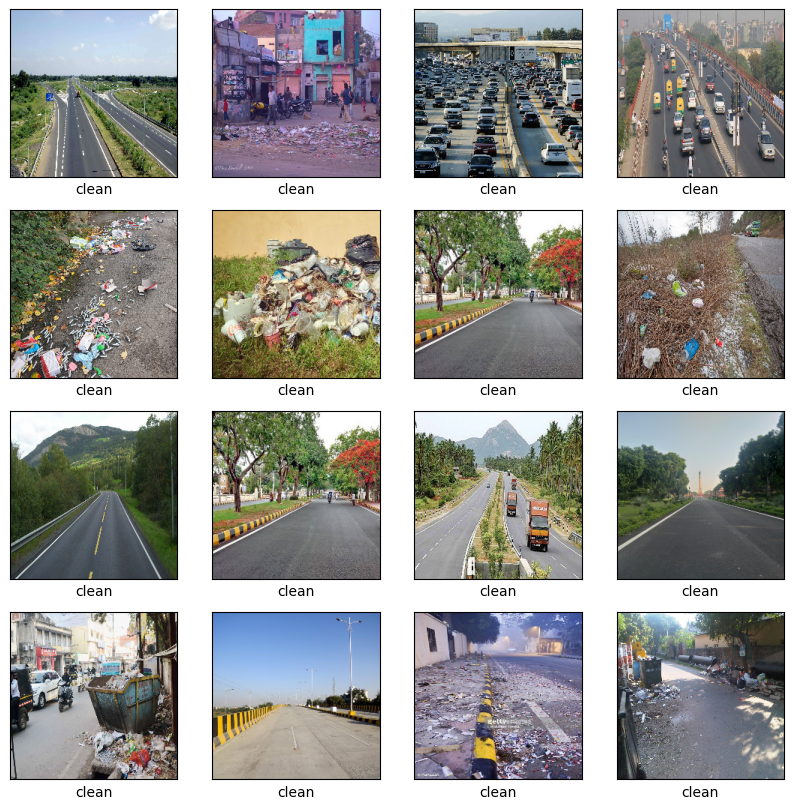

In [29]:
# Display 16 pictures from the dataset
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for x in range(4):
    for y in range(4):
        i = randint(0, len(images))

        axs[x][y].imshow(images[i])

        # delete x and y ticks and set x label as picture label
        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(class_names[np.argmax(labels[i])])

plt.show()

In [31]:
images_path = '/content/Images'

labels_df = pd.read_csv('/content/metadata.csv')
print('\n\nlabels dataframe: \n', labels_df.head(), '\n\n')

class_names = ('clean', 'dirty')
num_classes = len(class_names)

img_size = (224, 224, 3)

print(f'{num_classes} classes: {class_names}\nimage size: {img_size}')


labels = []
images = []

for index, row in labels_df.iterrows():
    file_path = images_path + '/' + row['filename']  # Construct the full file path
    image = cv2.imread(file_path, cv2.IMREAD_COLOR)

    if image is not None:
        image = cv2.resize(image, (img_size[1], img_size[0]))  # Resize
        image = image[:, :, ::-1]  # BGR to RGB
        images.append(image)

        # Labels will be in the form of a vector: [0, 1] or [1, 0]
        label = np.zeros(num_classes)
        label[row['label']] = 1
        labels.append(label)

labels = np.asarray(labels)
images = np.asarray(images)

print(f'labels shape: {labels.shape}')
print(f'images shape: {images.shape}')



labels dataframe: 
         filename  label
0    dirty_2.jpg      1
1   clean_36.jpg      0
2   clean_31.jpg      0
3   dirty_69.jpg      1
4  clean_113.jpg      0 


2 classes: ('clean', 'dirty')
image size: (224, 224, 3)
labels shape: (237, 2)
images shape: (237, 224, 224, 3)


In [32]:
# DEFINE TRAIN/TEST SPLIT
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1, random_state=42)

print(f'train images shape: {X_train.shape}\ntrain labels shape: {y_train.shape}\n\nvalidation images shape: {X_val.shape}\nvalidation labels shape: {y_val.shape}\n')

train images shape: (213, 224, 224, 3)
train labels shape: (213, 2)

validation images shape: (24, 224, 224, 3)
validation labels shape: (24, 2)



In [33]:
# ImageDataGenerator for train images
train_images_generator = tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.3,
                                                                         rotation_range=15,
                                                                         zoom_range=0.3,
                                                                         vertical_flip=True,
                                                                         horizontal_flip=True)
train_images_generator = train_images_generator.flow(X_train, y=y_train)

# ImageDataGenerator for validation images
validation_images_generator = tf.keras.preprocessing.image.ImageDataGenerator(vertical_flip=True,
                                                                              horizontal_flip=True)
validation_images_generator = validation_images_generator.flow(X_val, y=y_val)

## Compile and Train Model

In [44]:
do_fine_tuning = False

# Load the MobileNetV2 model from TensorFlow Hub without specifying the input shape
model = hub.KerasLayer(model_handle, trainable=do_fine_tuning)

# Create the rest of your custom model layers
custom_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names), kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

# Compile the custom model
custom_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

# Build the custom model to initialize it
custom_model.build((None,) + (224, 224, 3))

# Summarize the custom model
custom_model.summary()

train_size = X_train.shape[0]
valid_size = X_val.shape[0]
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = custom_model.fit(
    train_images_generator,
    epochs=20,
    verbose=1,
    validation_data=validation_images_generator, callbacks=[checkpoint_callback])


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_8 (KerasLayer)  (None, 1001)              3540265   
                                                                 
 dropout_5 (Dropout)         (None, 1001)              0         
                                                                 
 dense_5 (Dense)             (None, 2)                 2004      
                                                                 
Total params: 3542269 (13.51 MB)
Trainable params: 2004 (7.83 KB)
Non-trainable params: 3540265 (13.51 MB)
_________________________________________________________________
Epoch 1/20
7/7 [==============================] - 23s 3s/step - loss: 1.4170 - accuracy: 0.4085 - val_loss: 0.5752 - val_accuracy: 0.7083
Epoch 2/20
7/7 [==============================] - 16s 2s/step - loss: 0.7643 - accuracy: 0.6714 - val_loss: 0.4930 - val_accuracy: 0.7500
E

In [45]:
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(accuracy))

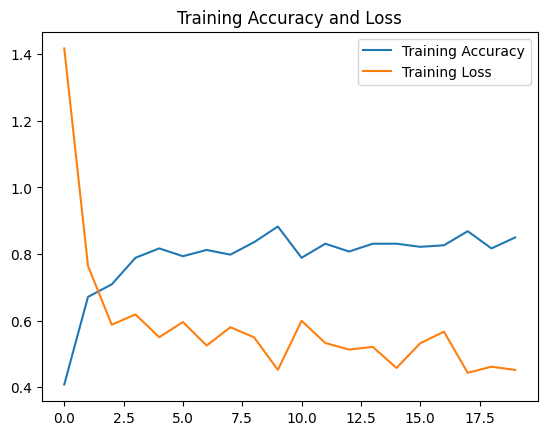

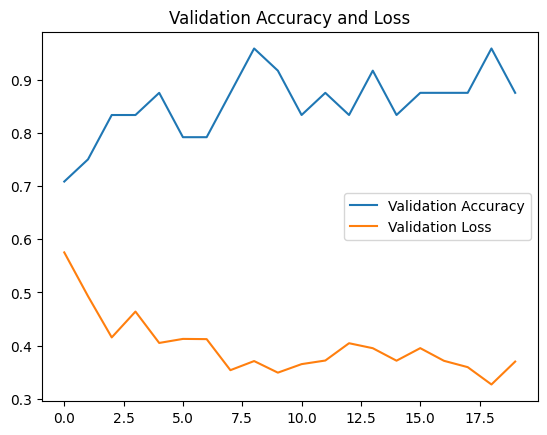

In [46]:
plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, loss, label='Training Loss')
plt.legend()
plt.title('Training Accuracy and Loss')

plt.figure()
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.title('Validation Accuracy and Loss')

plt.show()

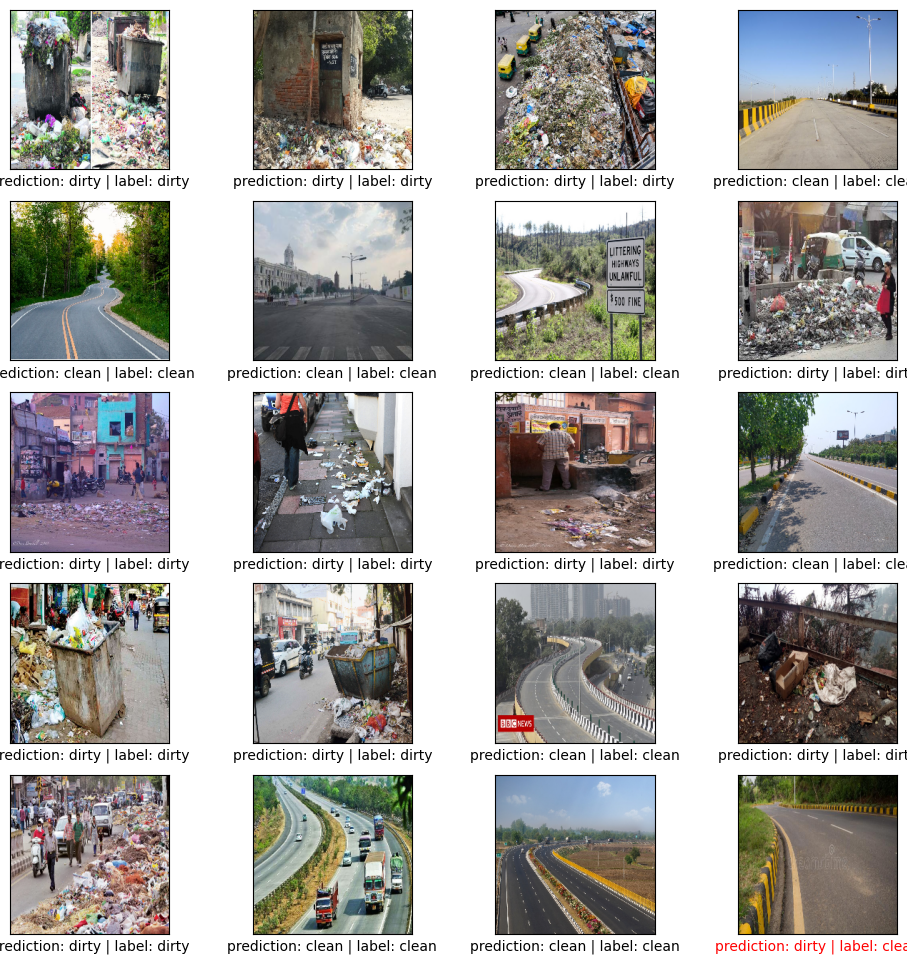

In [48]:
fig, axs = plt.subplots(5, 4, figsize=(12, 12))

i = 0
for x in range(5):
    for y in range(4):
        prediction = custom_model.predict(X_val[i][None, ...], verbose=0)[0]  # Use custom_model for predictions

        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])

        if np.argmax(prediction) != np.argmax(y_val[i]):
            axs[x][y].set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: {class_names[np.argmax(y_val[i])]}', color='red')
        else:
            axs[x][y].set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: {class_names[np.argmax(y_val[i])]}')

        axs[x][y].imshow(X_val[i])

        i += 1
plt.show()
